#Heart attack prediction 

### This markdown is for code for the datascience exam project 

Data analysis of Heart Attack Prediction dataset from Kaggle. Random forest classifiers.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz
import pickle

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score




#import warnings
#warnings.filterwarnings("ignore")

In [2]:
# Load data
DF = pd.read_csv("heart.csv")

print(DF)


     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     63    1   3     145   233    1        0       150     0      2.3    0   
1     37    1   2     130   250    0        1       187     0      3.5    0   
2     41    0   1     130   204    0        0       172     0      1.4    2   
3     56    1   1     120   236    0        1       178     0      0.8    2   
4     57    0   0     120   354    0        1       163     1      0.6    2   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
298   57    0   0     140   241    0        1       123     1      0.2    1   
299   45    1   3     110   264    0        1       132     0      1.2    1   
300   68    1   0     144   193    1        1       141     0      3.4    1   
301   57    1   0     130   131    0        1       115     1      1.2    1   
302   57    0   1     130   236    0        0       174     0      0.0    1   

     caa  thall  output  
0      0      1       1  

In [3]:
DF.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

In [4]:
# Checking if there are any NAs
DF.isnull().values.any()

False

In [5]:
#Choose what variables you want in x. : before comma means all rows, :13 after comma means all the 13 first columns

x = DF.iloc[:, :13]
x

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


In [6]:
x.values

array([[63.,  1.,  3., ...,  0.,  0.,  1.],
       [37.,  1.,  2., ...,  0.,  0.,  2.],
       [41.,  0.,  1., ...,  2.,  0.,  2.],
       ...,
       [68.,  1.,  0., ...,  1.,  2.,  3.],
       [57.,  1.,  0., ...,  1.,  1.,  3.],
       [57.,  0.,  1., ...,  1.,  1.,  2.]])

In [7]:
y = DF.iloc[:, -1]
y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: output, Length: 303, dtype: int64

In [8]:
y.values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [9]:
# Split into train and testsets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [10]:
# Fit the model // train model1 on training data
model1 = RandomForestClassifier()
model1.fit(x_train, y_train)

RandomForestClassifier()

In [11]:
# Test Model1 
prediction1 = model1.predict(x_test)

In [12]:
target_names = ["Low risk", "High risk"]

In [13]:
# Model performance
print(classification_report(y_test, prediction1, target_names= target_names))

              precision    recall  f1-score   support

    Low risk       0.79      0.63      0.70        30
   High risk       0.70      0.84      0.76        31

    accuracy                           0.74        61
   macro avg       0.75      0.74      0.73        61
weighted avg       0.75      0.74      0.73        61



Evaluate the optimal number of n_estimators

Text(0, 0.5, 'Testing Accuracy')

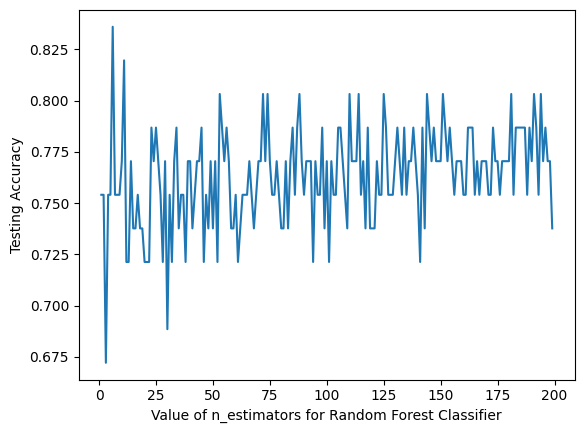

In [15]:

scores =[]
for k in range(1, 200):
    model1 = RandomForestClassifier(n_estimators=k)
    model1.fit(x_train, y_train)
    y_pred = model1.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))


%matplotlib inline

# plotting the relationship between number of estimators and testing accuracy
#plt.plot(x_axis, y_axis)
plt.plot(range(1, 200), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier Model 1')
plt.ylabel('Testing Accuracy')

So it seems that the testing accuracy does not get much better past an n_estimator value of 50

In [28]:
# Fit the model // train model1 on training data
model1 = RandomForestClassifier(max_features=13, n_estimators=50)
model1.fit(x_train, y_train)

# Test Model1 
prediction1 = model1.predict(x_test)

# Model performance
print(classification_report(y_test, prediction1, target_names= target_names))

              precision    recall  f1-score   support

    Low risk       0.78      0.70      0.74        30
   High risk       0.74      0.81      0.77        31

    accuracy                           0.75        61
   macro avg       0.76      0.75      0.75        61
weighted avg       0.76      0.75      0.75        61



The performance did not improve by this. 

Feature Importance of Random Forest model 1

In [18]:
# Fetch the variables which the model 'thinks' is best
pd.DataFrame(model1.feature_importances_, index=x_train.columns).sort_values(by=0, ascending=False)

,0
cp,0.277252
oldpeak,0.125961
caa,0.106165
thalachh,0.097515
chol,0.073810
trtbps,0.070182
age,0.065487
exng,0.059902
thall,0.046259
sex,0.039351


Correlation matrix

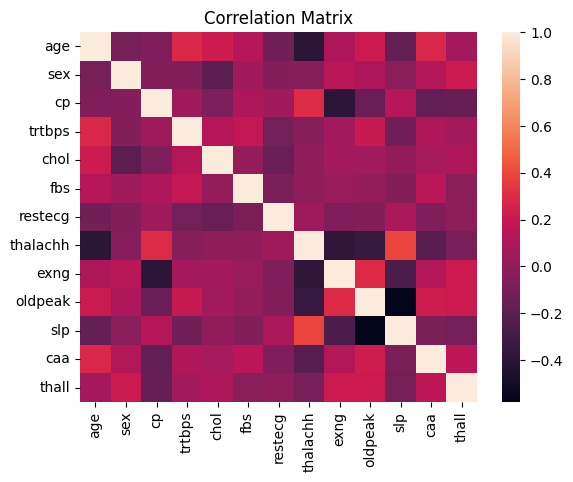

In [19]:
# Make a subset of the data to keep out the output variable
DF_nop = DF.iloc[:, :13]

# Correlation matrix / heatmap
corr_matrix = sns.heatmap(DF_nop.corr(),
                xticklabels=DF_nop.columns,
                yticklabels=DF_nop.columns)

corr_matrix.set_title('Correlation Matrix')
plt.show()

Build, train, test Model2

According to the model, the most important features are cp, oldpeak, and caa (see feature importance of Random Forest model1 further above).
The variables cp and thalachh are positively correlated (see correlation matrix) I therefore choose not to include the fourth variable on the feature importance output (thalachh)

In [31]:
x2 = DF.iloc[:, [2, 9, 11]]
x2

,cp,oldpeak,caa
0,3,2.3,0
1,2,3.5,0
2,1,1.4,0
3,1,0.8,0
4,0,0.6,0
...,...,...,...
298,0,0.2,0
299,3,1.2,0
300,0,3.4,2
301,0,1.2,1


In [32]:
# Split into train and testsets
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y, test_size=0.2, random_state=1)

In [33]:
# Fit the model // train model2 on training data
model2 = RandomForestClassifier()
model2.fit(x2_train, y2_train)

# Test Model2 
prediction2 = model2.predict(x2_test)

# Model performance
print(classification_report(y2_test, prediction2, target_names= target_names))

              precision    recall  f1-score   support

    Low risk       0.81      0.57      0.67        30
   High risk       0.68      0.87      0.76        31

    accuracy                           0.72        61
   macro avg       0.74      0.72      0.71        61
weighted avg       0.74      0.72      0.71        61



Model with all variables using XGBoost classifier

In [23]:
# Fit the model // train XGBmodel1 on training data
XGBmodel1 = XGBClassifier()
XGBmodel1.fit(x_train, y_train)

# Test model
XGBprediction1 = XGBmodel1.predict(x_test)

# Model performance
print(classification_report(y_test, XGBprediction1, target_names= target_names))

              precision    recall  f1-score   support

    Low risk       0.84      0.70      0.76        30
   High risk       0.75      0.87      0.81        31

    accuracy                           0.79        61
   macro avg       0.79      0.79      0.78        61
weighted avg       0.79      0.79      0.79        61



Feature importance of XGBoost model1

In [24]:
pd.DataFrame(XGBmodel1.feature_importances_, index=x_train.columns).sort_values(by=0, ascending=False)

,0
cp,0.279542
exng,0.166955
caa,0.119970
oldpeak,0.074536
sex,0.070020
thall,0.061043
chol,0.037126
restecg,0.036797
thalachh,0.034991
fbs,0.034373


This is slightly different than the output of the feature importance for Random Forest model1.
We should keep in mind that the variables exng and cp are highly correlated and so is exng and oldpeak (see correlation matrix)

I will therefore make two models, one with exng and one with oldpeak, to see performs best.

In [39]:
# x2 has the features cp, oldpeak, and caa

# Fit the model // train XGBmodel2 on the variables cp, oldpeak, and caa
XGBmodel2 = XGBClassifier()
XGBmodel2.fit(x2_train, y2_train)

# Test model
XGBprediction2 = XGBmodel2.predict(x2_test)

# Model performance
print(classification_report(y2_test, XGBprediction2, target_names= target_names))

              precision    recall  f1-score   support

    Low risk       0.77      0.57      0.65        30
   High risk       0.67      0.84      0.74        31

    accuracy                           0.70        61
   macro avg       0.72      0.70      0.70        61
weighted avg       0.72      0.70      0.70        61



Build XGBmodel 3 that is trained on cp, exng, and caa

In [38]:

x3 = DF.iloc[:, [2, 8, 11]]
x3


,cp,exng,caa
0,3,0,0
1,2,0,0
2,1,0,0
3,1,0,0
4,0,1,0
...,...,...,...
298,0,1,0
299,3,0,0
300,0,0,2
301,0,1,1


In [40]:
# Split into train and testsets
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y, test_size=0.2, random_state=1)

In [41]:
# Fit the model // train XGBmodel3 on the variables cp, exng, and caa
XGBmodel3 = XGBClassifier()
XGBmodel3.fit(x3_train, y3_train)

# Test model
XGBprediction3 = XGBmodel3.predict(x3_test)

# Model performance
print(classification_report(y3_test, XGBprediction3, target_names= target_names))

              precision    recall  f1-score   support

    Low risk       0.72      0.60      0.65        30
   High risk       0.67      0.77      0.72        31

    accuracy                           0.69        61
   macro avg       0.69      0.69      0.69        61
weighted avg       0.69      0.69      0.69        61



Build XGBmodel 4 based on literature

In [42]:
#xt = DF.iloc[:, [2, 8, 11]]

# Split into train and testsets
xt_train, xt_test, yt_train, yt_test = train_test_split(xt, y, test_size=0.2, random_state=1)

# Fit the model // train XGBmodel3 on the variables cp, exng, and caa
XGBmodelt = XGBClassifier()
XGBmodelt.fit(xt_train, yt_train)

# Test model
XGBpredictiont = XGBmodelt.predict(xt_test)

# Model performance
print(classification_report(yt_test, XGBpredictiont, target_names= target_names))

              precision    recall  f1-score   support

    Low risk       0.72      0.60      0.65        30
   High risk       0.67      0.77      0.72        31

    accuracy                           0.69        61
   macro avg       0.69      0.69      0.69        61
weighted avg       0.69      0.69      0.69        61

